<a href="https://colab.research.google.com/github/kairamilanifitria/PurpleBox-Intern/blob/main/02_13_Chunking_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Document-Spesific Chunking

In [ ]:
from langchain.text_splitter import MarkdownHeaderTextSplitter

with open("/content/PDF1 (2).md","r") as file:
  markdown_text = file.read()

headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2")
]

splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on,
    strip_headers=False
)

In [ ]:
chunks = splitter.split_text(markdown_text)

In [ ]:
for i, chunk in enumerate(chunks):
  print(f"chunk {i+1}: \n{chunk}")

chunk 1: 
page_content='## A Hype-Adjusted Probability Measure for NLP Stock Return Forecasting  
Zheng Cao ∗ zcao26@jh.edu  
Hélyette Geman †  
hgeman1@jhu.edu' metadata={'Header 2': 'A Hype-Adjusted Probability Measure for NLP Stock Return Forecasting'}
chunk 2: 
page_content='## Abstract  
This article introduces a Hype-Adjusted Probability Measure in the context of a new Natural Language Processing (NLP) approach for stock return and volatility forecasting. A novel sentiment score equation is proposed to represent the impact of intraday news on forecasting next-period stock return and volatility for selected U.S. semiconductor tickers, a very vibrant industry sector. This work improves the forecast accuracy by addressing news bias, memory, and weight, and incorporating shifts in sentiment direction. More importantly, it extends the use of the remarkable tool of change of Probability Measure developed in the finance of Asset Pricing to NLP forecasting by constructing a Hype-Adjusted

# Semantic Chunkers

### Semantic Chunking
Semantic-based chunking involves splitting text into chunks based on the meaning of the content rather than fixed length or sentence boundaries. The idea is to group related information, which may vary in length, into semantic units. This is often done using NLP techniques, such as sentence embeddings or document clustering, to identify the most relevant sections for each chunk.

Use Case:
Best for use in situations where meaningful semantic units (e.g., paragraphs, topics) should be grouped together regardless of the chunk size. This is useful for document summarization, knowledge extraction, and other advanced NLP tasks.

In [ ]:
from langchain.text_splitter import MarkdownHeaderTextSplitter
from sentence_transformers import SentenceTransformer
import numpy as np
import torch
import re

# Load Markdown file
with open("/content/PDF1 (2).md", "r") as file:
    markdown_text = file.read()

# Step 1: Document-Specific Chunking
headers_to_split_on = [("#", "Header 1"), ("##", "Header 2")]
splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on, strip_headers=False)
chunks = splitter.split_text(markdown_text)


In [ ]:
# Step 2: Identify long text chunks (excluding tables and images)
def is_table_or_image(chunk):
    return "![](" in chunk or "|" in chunk  # Simple check for images and tables

def needs_semantic_chunking(chunk, max_tokens=512):
    return not is_table_or_image(chunk) and len(chunk.split()) > max_tokens

In [ ]:
# Load Hugging Face Embedding Model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def semantic_split(text, max_sentences=5):
    sentences = re.split(r'(?<=[.!?])\s+', text)  # Split by sentence
    embeddings = model.encode(sentences, convert_to_tensor=True)

    # Compute cosine similarity
    similarities = torch.nn.functional.cosine_similarity(embeddings[:-1], embeddings[1:])

    # Find split points where similarity drops
    split_points = [i+1 for i, sim in enumerate(similarities) if sim < 0.5]  # Threshold 0.5 (tune as needed)

    # Generate new chunks
    sub_chunks, start = [], 0
    for split in split_points:
        sub_chunks.append(" ".join(sentences[start:split]))
        start = split
    sub_chunks.append(" ".join(sentences[start:]))  # Add remaining text

    return [c for c in sub_chunks if c]

In [ ]:
# Step 3: Apply Semantic Chunking where needed
final_chunks = []
for chunk in chunks:
    text = chunk.page_content  # Extract text from Document object
    if needs_semantic_chunking(text):
        final_chunks.extend(semantic_split(text))
    else:
        final_chunks.append(text)

# Print final chunks
for i, chunk in enumerate(final_chunks):
    print(f"Chunk {i+1}:\n{chunk}\n---\n")

Chunk 1:
## A Hype-Adjusted Probability Measure for NLP Stock Return Forecasting  
Zheng Cao ∗ zcao26@jh.edu  
Hélyette Geman †  
hgeman1@jhu.edu
---

Chunk 2:
## Abstract  
This article introduces a Hype-Adjusted Probability Measure in the context of a new Natural Language Processing (NLP) approach for stock return and volatility forecasting. A novel sentiment score equation is proposed to represent the impact of intraday news on forecasting next-period stock return and volatility for selected U.S. semiconductor tickers, a very vibrant industry sector. This work improves the forecast accuracy by addressing news bias, memory, and weight, and incorporating shifts in sentiment direction. More importantly, it extends the use of the remarkable tool of change of Probability Measure developed in the finance of Asset Pricing to NLP forecasting by constructing a Hype-Adjusted Probability Measure, obtained from a redistribution of the weights in the probability space, meant to correct for exces

some chunks too short if using semantic chunking, like this :

Chunk 93:
*Similarly, for volatility direction, accuracy increases from 53 8% .*

Chunk 94:
*in the baseline model to 72 1% . and 75 0% .*

Chunk 95:
*in the corresponding models.*

Chunk 96:
*These substantial improvements validate the effectiveness of our methodology.*

Chunk 97:
*The observed accuracy increase of +8 3% .*


Chunk 98:
*for market return direction and +2 9% .*

## Advanced Semantic Chunking

the previous method are not maintain the content of image description and split it, so it will lost the context of image description.
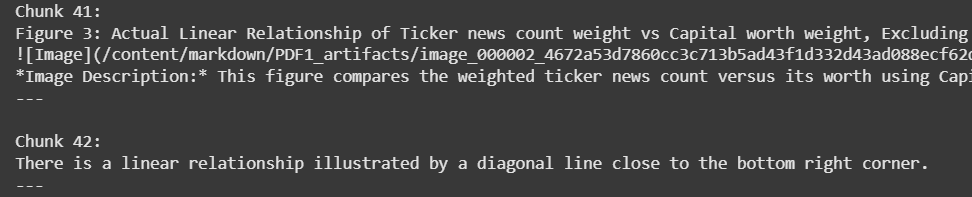

**Key Objectives:**

**Prevents Short Chunks:**

- Ensures chunks have at least 10 words to avoid fragmentation.

**Avoids Overlapping Sentences:**

- Instead of sliding windows, it splits only at significant semantic breaks.

**Preserves Image Descriptions**:

- If an image chunk is found, the next chunk (likely its description) is merged with it.

**Dynamic Similarity Threshold**:

- Uses cosine similarity to determine natural breakpoints, ensuring that strongly related sentences stay together.

In [5]:
chunk_lengths = [len(chunk.split()) for chunk in final_chunks]

print("Chunk Lengths:", chunk_lengths)
print("Min Chunk Length:", min(chunk_lengths))
print("Max Chunk Length:", max(chunk_lengths))
print("Average Chunk Length:", sum(chunk_lengths) / len(chunk_lengths))


Chunk Lengths: [18, 140, 233, 61, 88, 88, 66, 58, 66, 79, 130, 114, 100, 42, 32, 24, 16, 78, 111, 110, 69, 51, 89, 87, 92, 59, 63, 209, 767, 177, 85, 48, 72, 69, 68, 58, 54, 70, 63, 61, 58, 58, 53, 54, 43, 51, 45, 45, 45, 46, 61, 57, 72, 60, 65, 80, 72, 66, 54, 99, 98, 408, 18, 108, 156, 166, 413, 33, 204, 404, 176, 86, 95, 53, 52, 57, 65, 91, 92, 84, 54, 63, 62, 40, 43, 31, 48, 34, 68, 65, 66, 69, 68, 79, 83, 109, 33, 311, 52, 45, 97, 52, 91, 68, 44, 23, 64, 75, 66, 53, 67, 68, 50, 32, 35, 25, 27, 22, 22, 16, 17, 21, 25, 28, 41, 58, 105, 43, 43, 46, 68, 95, 90, 83, 87, 78, 82, 169, 519, 477]
Min Chunk Length: 16
Max Chunk Length: 767
Average Chunk Length: 90.02142857142857


In [10]:
from langchain.text_splitter import MarkdownHeaderTextSplitter
from sentence_transformers import SentenceTransformer
import numpy as np
import torch
import re

# Load Markdown file
with open("/content/PDF1 (2).md", "r") as file:
    markdown_text = file.read()

# Step 1: Document-Specific Chunking
headers_to_split_on = [("#", "Header 1"), ("##", "Header 2")]
splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on, strip_headers=False)
documents = splitter.split_text(markdown_text)  # Returns list of Document objects
chunks = [doc.page_content for doc in documents]  # Extract raw text


In [11]:
# Step 2: Identify long text chunks (excluding tables and images)
def is_table_or_image(chunk):
    return "![](" in chunk or "|" in chunk  # Simple check for images and tables

def needs_semantic_chunking(chunk, max_tokens=512):
    return not is_table_or_image(chunk) and len(chunk.split()) > max_tokens

# Load Hugging Face Embedding Model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def semantic_split(text, max_sentences=5, similarity_threshold=0.6):
    sentences = re.split(r'(?<=[.!?])\s+', text)  # Split by sentence
    if len(sentences) <= max_sentences:  # No need to split
        return [text]

    embeddings = model.encode(sentences, convert_to_tensor=True)

    # Compute cosine similarity between consecutive sentences
    similarities = torch.nn.functional.cosine_similarity(embeddings[:-1], embeddings[1:], dim=1)

    # Find breakpoints where similarity is low
    split_points = [i+1 for i, sim in enumerate(similarities) if sim < similarity_threshold]

    # Generate new chunks while preventing ultra-short ones
    sub_chunks, start = [], 0
    for split in split_points:
        chunk_text = " ".join(sentences[start:split])
        if len(chunk_text.split()) >= 10:  # Ensure reasonable chunk size
            sub_chunks.append(chunk_text)
            start = split
    sub_chunks.append(" ".join(sentences[start:]))  # Add remaining text

    return [c for c in sub_chunks if len(c.split()) >= 10]  # Filter out tiny chunks


In [12]:
# Step 3: Apply Semantic Chunking where needed
final_chunks = []
for chunk in chunks:
    if needs_semantic_chunking(chunk):
        final_chunks.extend(semantic_split(chunk))
    else:
        final_chunks.append(chunk)

# Step 4: Merge Image Descriptions with Their Images
merged_chunks = []
for i, chunk in enumerate(final_chunks):
    if "![](" in chunk and i + 1 < len(final_chunks):  # If chunk has image
        next_chunk = final_chunks[i + 1]
        if len(next_chunk.split()) < 50:  # Likely an image description
            chunk += "\n" + next_chunk
            final_chunks[i + 1] = ""  # Mark for removal
    merged_chunks.append(chunk)

# Remove empty placeholders
merged_chunks = [chunk for chunk in merged_chunks if chunk]

# Print final chunks
for i, chunk in enumerate(merged_chunks):
    print(f"Chunk {i+1}:\n{chunk}\n---\n")

Chunk 1:
## A Hype-Adjusted Probability Measure for NLP Stock Return Forecasting  
Zheng Cao ∗ zcao26@jh.edu  
Hélyette Geman †  
hgeman1@jhu.edu
---

Chunk 2:
## Abstract  
This article introduces a Hype-Adjusted Probability Measure in the context of a new Natural Language Processing (NLP) approach for stock return and volatility forecasting. A novel sentiment score equation is proposed to represent the impact of intraday news on forecasting next-period stock return and volatility for selected U.S. semiconductor tickers, a very vibrant industry sector. This work improves the forecast accuracy by addressing news bias, memory, and weight, and incorporating shifts in sentiment direction. More importantly, it extends the use of the remarkable tool of change of Probability Measure developed in the finance of Asset Pricing to NLP forecasting by constructing a Hype-Adjusted Probability Measure, obtained from a redistribution of the weights in the probability space, meant to correct for exces

result is better because maintain the tables, image path, and image description as well.

# Advanced Chunking Method using "Late Chunking"

some of the chunk can lose its context if the next chunk was written by "it". We need to define the context independently for each chunks

In [13]:
## will do